In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import math 
import random
from tqdm import tqdm

from multiprocessing import Pool

# user defined module
import utils as ut

sns.set_theme(style="whitegrid")
sns.set_context('paper')

In [12]:
file_name = 'results.csv'
df = pd.read_csv(file_name, delimiter=",", decimal=".", 
    names=['prog','flag','pkg','pp0','time'])


flags = df['flag'].unique()
progs = df['prog'].unique()

print(f"Flags ({len(flags)}) : {flags}")
print(f"Programs ({len(progs)}) : {progs}")

x_id = 'flag'
x_values = df[x_id].unique()

y_id = 'prog'
y_values = df[y_id].unique()

print(f"X ({len(x_values)}) : {x_values}")
print(f"Y ({len(y_values)}) : {y_values}")

# Column label that contains the data to be analysed
DATA_COL = 'pkg'

display(df)

Flags (4) : ['-O0' '-O1' '-O2' '-O3']
Programs (4) : ['bubblesort' 'bubblesort_optimized' 'bubblesort_ll'
 'bubblesort_ll_optimized']
X (4) : ['-O0' '-O1' '-O2' '-O3']
Y (4) : ['bubblesort' 'bubblesort_optimized' 'bubblesort_ll'
 'bubblesort_ll_optimized']


,prog,flag,pkg,pp0,time
0,bubblesort,-O0,1.746033,1.489990,290.180
1,bubblesort,-O0,1.747253,1.497620,286.229
2,bubblesort,-O0,1.773926,1.517700,286.435
3,bubblesort,-O0,1.840271,1.580444,289.628
4,bubblesort,-O0,1.761414,1.509216,284.645
...,...,...,...,...,...
6395,bubblesort_ll_optimized,-O3,1.763000,1.490479,292.394
6396,bubblesort_ll_optimized,-O3,1.830811,1.539185,306.288
6397,bubblesort_ll_optimized,-O3,1.768250,1.497131,293.608
6398,bubblesort_ll_optimized,-O3,1.772949,1.496704,292.624


## Remove Outliers

In [13]:
df_len = len(df)

for x in x_values:
    for y in y_values:
        data = df[(df[y_id] == y) & (df[x_id] == x)]

        q75, q25 = data[DATA_COL].quantile(q=0.75), data[DATA_COL].quantile(q=0.25) # np.percentile(data.loc[:,data_column],[75,25])
        intr_qr = q75 - q25

        max = q75 + (1.5 * intr_qr)
        min = q25 - (1.5 * intr_qr)

        data.loc[data[DATA_COL] < min,DATA_COL] = np.nan
        data.loc[data[DATA_COL] > max,DATA_COL] = np.nan

        df[(df[y_id] == y) & (df[x_id] == x)] = data.dropna(axis=0)        

df = df.dropna(axis=0)

print(f"Removed {df_len - len(df)} outliers")

Removed 372 outliers


In [28]:
mean_df = []

for flag in flags:
    for prog in progs: 
        mean_df = [*mean_df, [flag, prog, df[(df['prog'] == prog) & (df['flag'] == flag)][DATA_COL].mean()]]

mean_df = pd.DataFrame(mean_df, columns=['flag', 'prog', 'mean'])
print(mean_df)

   flag                     prog      mean
0   -O0               bubblesort  1.833105
1   -O0     bubblesort_optimized  1.838425
2   -O0            bubblesort_ll  2.224905
3   -O0  bubblesort_ll_optimized  3.349698
4   -O1               bubblesort  1.052437
5   -O1     bubblesort_optimized  1.059576
6   -O1            bubblesort_ll  1.677081
7   -O1  bubblesort_ll_optimized  2.496690
8   -O2               bubblesort  0.845637
9   -O2     bubblesort_optimized  0.849415
10  -O2            bubblesort_ll  1.325642
11  -O2  bubblesort_ll_optimized  2.005846
12  -O3               bubblesort  1.543173
13  -O3     bubblesort_optimized  1.545018
14  -O3            bubblesort_ll  1.341371
15  -O3  bubblesort_ll_optimized  1.763502


In [25]:
to_test = []
norm_df = []

for flag in flags:
    for i, prog1 in enumerate(progs):
        for j in range(i + 1, len(progs)):
            norm_df.append([flag, prog1, progs[j], False, 0])
            to_test.append((prog1, progs[j], flag))

norm_df = pd.DataFrame(norm_df, columns=['flag', 'prog1', 'prog2', 'sig', 'diff'])
print(len(to_test))
# print(norm_df)

def ab_test(sample):
    prog1, prog2, flag = sample

    baseline = df[(df['prog'] == prog1) & (df['flag'] == flag)]
    data = df[(df['prog'] == prog2) & (df['flag'] == flag)]

    if len(data) < 1: return

    pvalue, _, _ = ut.random_sampling(baseline, data, DATA_COL, 100000, log=False)

    mean = ( (baseline[DATA_COL].mean() - data[DATA_COL].mean()) / baseline[DATA_COL].mean() ) * 100
    return prog1, prog2, flag, pvalue, mean


# bubblesort bubblesort_optimized -O0
        # i = norm_df.index[(norm_df['prog1'] == prog1) & (norm_df['prog2'] == prog2) & (norm_df['flag'] == flag)]


with Pool() as pool:
    results = pool.map(ab_test, to_test)

    for prog1, prog2, flag, pvalue, mean in results:
        i = norm_df.index[(norm_df['prog1'] == prog1) & (norm_df['prog2'] == prog2) & (norm_df['flag'] == flag)].values[0]
        norm_df.at[i, 'sig'] = pvalue < 0.05
        norm_df.at[i, 'diff'] = mean

norm_df

24


,flag,prog1,prog2,sig,diff
0,-O0,bubblesort,bubblesort_optimized,True,-0.290210
1,-O0,bubblesort,bubblesort_ll,True,-21.373519
2,-O0,bubblesort,bubblesort_ll_optimized,True,-82.733494
3,-O0,bubblesort_optimized,bubblesort_ll,True,-21.022300
4,-O0,bubblesort_optimized,bubblesort_ll_optimized,True,-82.204718
5,-O0,bubblesort_ll,bubblesort_ll_optimized,True,-50.554664
6,-O1,bubblesort,bubblesort_optimized,True,-0.678386
7,-O1,bubblesort,bubblesort_ll,True,-59.352221
8,-O1,bubblesort,bubblesort_ll_optimized,True,-137.229474
9,-O1,bubblesort_optimized,bubblesort_ll,True,-58.278482


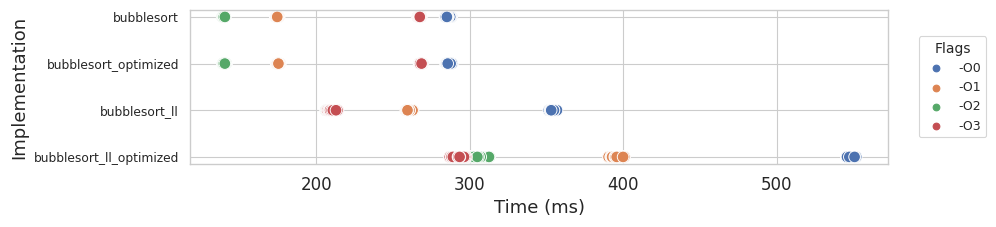

In [8]:
plt.figure(figsize=(9,2))
sns.set_theme(style="whitegrid")
sns.set_context("paper")
ax = sns.scatterplot(data=df, x=DATA_COL, y="prog", hue="flag", s=70)

plt.xticks(fontsize=12)
ax.set_ylabel("Implementation", fontsize = 13)
ax.set_xlabel("Energy (J)" if DATA_COL in ['pkg', 'pp0'] else "Time (ms)", fontsize = 13)

ax.legend(loc="right", bbox_to_anchor=(1.15,.5), ncols=1, title='Flags', fontsize=9, title_fontsize=10)

plt.savefig(f"charts/{DATA_COL}_prog.png", bbox_inches='tight')
# plt.show()

## Normal Distribution Tests

In [9]:
from scipy.stats import shapiro
from scipy.stats import normaltest

p_threshold = 0.05
norm_df = []

for x in x_values:
    for y in y_values:
        data = df[(df[y_id] == y) & (df[x_id] == x)][DATA_COL].values

        if not len(data):
            continue

        # Shapiro-Wilk Test
        # Tests whether a data sample has a Gaussian distribution
        #   Assumptions
        #       - observations in each sample are independent and identically distributed
        #   Interpretation:
        #       - H0: the sample has a Gaussian distribution (pvalue < 0.05)
        #       - H1: the sample does not have a Gaussian distribution (pvalue >= 0.05)
        _, p = shapiro(data)
        res_shapiro = p >= p_threshold

        # D'Agostino's K² Test
        # Tests whether a data sample has a Gaussian distribution
        #   Assumptions
        #       - observations in each sample are independent and identically distributed
        #   Interpretation
        #       - H0: the sample has a Gaussian distribution (pvalue < 0.05)
        #       - H1: the sample does not have a Gaussian distribution (pvalue >= 0.05)
        _, p = normaltest(data)
        res_agostino = p >= p_threshold
        
        # Anderson-Darling Test
        # Tests whether a data sample has a Gaussian distribution
        #   Assumptions
        #       - observations in each sample are independent and identically distributed
        #   Interpretation
        #       - H0: the sample has a Gaussian distribution
        #       - H1: the sample does not have a Gaussian distribution 
        p = ut.anderson(data)
        res_anderson = p >= p_threshold

        # decide how to combine the results of the 3 normality tests
        # TODO: maybe we can add weights to this?
        is_normal = res_shapiro and res_agostino and res_anderson

        norm_df.append([x, y, res_shapiro, res_agostino, res_anderson, is_normal])

norm_df = pd.DataFrame(norm_df, columns=[x_id, y_id, 'shapiro', 'agostino', 'anderson', 'normal'])

norm_df

,flag,prog,shapiro,agostino,anderson,normal
0,-O0,bubblesort,False,False,False,False
1,-O0,bubblesort_optimized,False,False,False,False
2,-O0,bubblesort_ll,True,True,True,True
3,-O0,bubblesort_ll_optimized,False,False,False,False
4,-O1,bubblesort,True,True,True,True
5,-O1,bubblesort_optimized,False,False,False,False
6,-O1,bubblesort_ll,False,False,False,False
7,-O1,bubblesort_ll_optimized,True,True,True,True
8,-O2,bubblesort,True,True,True,True
9,-O2,bubblesort_optimized,True,True,True,True


## Homogeneity of Variance

In [8]:
# Levene's Test
# Tests whether the observations in each sample have the same variance.
#   Interpretation
#       - H0: The null hypothesis of Levene’s test is that all groups have equal variances (pvalue < 0.05)
#       - H1: The alternative hypothesis of Levene’s test is that at least one pair of groups has unequal variances (pvalue >= 0.05)

from scipy.stats import levene


norm_df['levene'] = [False] * len(norm_df)

# for y_values that follow a normal distribution
for y in norm_df[(norm_df['normal'] == True)][y_id].unique():
    normal_flags = norm_df[(norm_df[y_id] == y) & (norm_df['normal'] == True)]['flag'].values.tolist()
    normal_flags.remove('-O0')

    if len(normal_flags) < 1: continue

    for flag in normal_flags:
        data = [df[(df['prog'] == prog) & (df['flag'] == f)][DATA_COL] for f in [flag, '-O0']]
        _, pvalue = levene(*data)

        # update value on dataframe
        i = norm_df.index[(norm_df['prog'] == prog) & (norm_df['flag'] == flag)].values[0]
        norm_df.at[i, 'levene'] = pvalue >= p_threshold

norm_df

,prog,flag,shapiro,agostino,anderson,normal,levene
0,bubblesort,-O0,False,False,False,False,False
1,bubblesort,-O1,True,True,True,True,False
2,bubblesort,-O2,True,True,True,True,False
3,bubblesort,-O3,False,False,False,False,False
4,bubblesort_optimized,-O0,False,False,False,False,False
5,bubblesort_optimized,-O1,True,True,True,True,False
6,bubblesort_optimized,-O2,False,True,False,False,False
7,bubblesort_optimized,-O3,True,True,True,True,False
8,bubblesort_ll,-O0,True,True,False,False,False
9,bubblesort_ll,-O1,False,True,False,False,False


## Is there a significant difference?

#### Analysis of Variance (ANOVA)

In [9]:
# Analysis of Variance Test (ANOVA)
# Tests whether the means of two or more independent samples are significantly different.
#   Assumptions:
#       - Observations in each sample are independent and identically distributed
#       - Observations in each sample are normally distributed
#       - Observations in each sample have the same variance
#   Interpretation
#       - H0: the means of the samples are equal (pvalue < 0.05)
#       - H1: one or more of the means of the samples are unequal (pvalue >= 0.05)

from scipy.stats import f_oneway

n_flags = list(flags)
n_flags.remove('-O0')

# get programs for which '-O0' data is normal and homogenous
to_test = norm_df[(norm_df['flag'] == '-O0') & (norm_df['normal'] == True)]['prog'].unique()

# create new column for anova results
norm_df['anova'] = [False] * len(norm_df)

for prog in to_test:
    normal_flags = norm_df[(norm_df['prog'] == prog) 
        & (norm_df['normal'] == True)
        & (norm_df['levene'] == True)]['flag'].values.tolist()

    # skip program if no flags respect assumptions
    if len(normal_flags) < 1: continue

    baseline = df[(df['prog'] == prog) & (df['flag'] == '-O0')][DATA_COL]
    
    for flag in normal_flags:
        data = df[(df['prog'] == prog) & (df['flag'] == flag)][DATA_COL]

        _, pvalue = f_oneway(baseline, data)

        # update value on dataframe
        i = norm_df.index[(norm_df['prog'] == prog) & (norm_df['flag'] == flag)].values[0]
        norm_df.at[i, 'anova'] = pvalue < p_threshold

norm_df

,prog,flag,shapiro,agostino,anderson,normal,levene,anova
0,bubblesort,-O0,False,False,False,False,False,False
1,bubblesort,-O1,True,True,True,True,False,False
2,bubblesort,-O2,True,True,True,True,False,False
3,bubblesort,-O3,False,False,False,False,False,False
4,bubblesort_optimized,-O0,False,False,False,False,False,False
5,bubblesort_optimized,-O1,True,True,True,True,False,False
6,bubblesort_optimized,-O2,False,True,False,False,False,False
7,bubblesort_optimized,-O3,True,True,True,True,False,False
8,bubblesort_ll,-O0,True,True,False,False,False,False
9,bubblesort_ll,-O1,False,True,False,False,False,False


#### Random Sampling
 - H0: df1 and df2 have the same distribution, the difference in samples is due to chance
 - H1: df1's average is lower than df2's

In [10]:
REPS = 200000


# programs that do not respect anova assumptions
norm_progs = norm_df[((norm_df['normal'] == False) | (norm_df['levene'] == False))]['prog'].unique()


task = [] # [(prog, flag), ...]
for prog in norm_progs:
    # flags that do not respect the assumptions of anova
    n_flags = norm_df[(norm_df['prog'] == prog) & ((norm_df['normal'] == False) | (norm_df['levene'] == False)) & (norm_df['flag'] != '-O0')]['flag'].values
    task = [*task, *[(prog, flag) for flag in n_flags]]

print(len(task))

def ab_test(sample):
    prog, flag = sample

    baseline = df[(df['prog'] == prog) & (df['flag'] == '-O0')]
    data = df[(df['prog'] == prog) & (df['flag'] == flag)]

    if len(data) < 1: return

    pvalue, _, _ = ut.random_sampling(baseline, data, DATA_COL, REPS, log=False)

    return prog, flag, pvalue

norm_df['random'] = [False] * len(norm_df)

with Pool() as pool:
    results = pool.map(ab_test, task)

    for prog, flag, pvalue in results:
        i = norm_df.index[(norm_df['prog'] == prog) & (norm_df['flag'] == flag)].values[0]
        norm_df.at[i, 'random'] = pvalue < p_threshold

norm_df

12


KeyboardInterrupt: 

## Effect Sizes

In [ ]:
to_test = norm_df[(norm_df['anova'] == True) | (norm_df['random'] == True)]['prog'].unique()

# create new column for cohend and hedgesg results
norm_df['cohend'] = [0.0] * len(norm_df)
norm_df['hedgesg'] = [0.0] * len(norm_df)

for prog in to_test:
    normal_flags = norm_df[(norm_df['prog'] == prog) 
        & ((norm_df['anova'] == True) | (norm_df['random'] == True))
        ]['flag'].values.tolist()

    # skip program if no flags respect assumptions
    if len(normal_flags) < 1: continue

    baseline = df[(df['prog'] == prog) & (df['flag'] == '-O0')][DATA_COL]
    
    for flag in normal_flags:
        data = df[(df['prog'] == prog) & (df['flag'] == flag)][DATA_COL]

        # update value on dataframe
        i = norm_df.index[(norm_df['prog'] == prog) & (norm_df['flag'] == flag)].values[0]
        
        # cohend 
        norm_df.at[i, 'cohend'] = ut.cohend(baseline, data)
        # hedge's g
        norm_df.at[i, 'hedgesg'] = ut.hedgesg(baseline, data)

# effsize > 0: decrease in consumption
# effsize < 0: increase in consumption

norm_df

,prog,flag,shapiro,agostino,anderson,normal,levene,anova,random,cohend,hedgesg
0,bubblesort,-O0,False,False,False,False,False,False,False,0.000000,0.000000
1,bubblesort,-O1,True,True,True,True,False,False,True,158.611427,157.360532
2,bubblesort,-O2,True,True,True,True,False,False,True,214.234251,212.602371
3,bubblesort,-O3,True,True,True,True,False,False,True,26.410170,26.171978
4,bubblesort_optimized,-O0,False,False,False,False,False,False,False,0.000000,0.000000
5,bubblesort_optimized,-O1,False,False,False,False,False,False,True,163.967008,163.565576
6,bubblesort_optimized,-O2,True,True,True,True,False,False,True,217.306730,216.223818
7,bubblesort_optimized,-O3,False,False,False,False,False,False,True,26.373672,26.449201
8,bubblesort_ll,-O0,True,True,True,True,False,False,False,0.000000,0.000000
9,bubblesort_ll,-O1,False,False,False,False,False,False,True,100.307310,100.316925


In [ ]:
# HEATMAP
heat_df = []
for flag in flags:
    if flag == '-O0': continue

    for prog in progs:
        data = norm_df[(norm_df['prog'] == prog) & (norm_df['flag'] == flag)]
        if data.empty: continue

        significant = data['anova'].values[0] or data['random'].values[0]
        effsize = data['hedgesg'].values[0]

        category = 0 if not significant else -1 if effsize < 0 else 1
        test = 1 if data['normal'].values[0] and data['levene'].values[0] else 2

        heat_df.append([flag, prog, category, test])

heat_df = pd.DataFrame(heat_df, columns=['flag', 'prog', 'category', 'test'])
heat_df

,flag,prog,category,test
0,-O1,bubblesort,1,2
1,-O1,bubblesort_optimized,1,2
2,-O1,bubblesort_ll,1,2
3,-O1,bubblesort_ll_optimized,1,2
4,-O2,bubblesort,1,2
5,-O2,bubblesort_optimized,1,2
6,-O2,bubblesort_ll,1,2
7,-O2,bubblesort_ll_optimized,1,2
8,-O3,bubblesort,1,2
9,-O3,bubblesort_optimized,1,2


In [ ]:
flag_stats = []

for flag in flags:
    if flag == '-O0': continue

    data = heat_df[heat_df['flag'] == flag]['category'].values

    total = len(data)

    more = len(data[data < 0])  # increase in consumption
    same = len(data[data == 0])
    less = len(data[data > 0])  # decrease in consumption

    perc = lambda x: (x / total) * 100

    flag_stats.append([flag, more, same, less, perc(more), perc(same), perc(less)])

flag_stats = pd.DataFrame(flag_stats, columns=['flag', '# more', '# same', '# less', '% more', '% same', '% less'])

display(flag_stats)

print(f"more > less: {len(flag_stats[flag_stats['# more'] > flag_stats['# less']])}\t({(len(flag_stats[flag_stats['# more'] > flag_stats['# less']]) / len(flag_stats)) * 100:.2f} %)")
print(f"more = less: {len(flag_stats[flag_stats['# more'] == flag_stats['# less']])}\t({(len(flag_stats[flag_stats['# more'] == flag_stats['# less']]) / len(flag_stats)) * 100:.2f} %)")
print(f"more < less: {len(flag_stats[flag_stats['# more'] < flag_stats['# less']])}\t({(len(flag_stats[flag_stats['# more'] < flag_stats['# less']]) / len(flag_stats)) * 100:.2f} %)")
# print(f"same > 16  : {len(flag_stats[flag_stats['# same'] > 16])}\t({(len(flag_stats[flag_stats['# same'] > 16]) / len(flag_stats)) * 100:.2f} %)")


,flag,# more,# same,# less,% more,% same,% less
0,-O1,0,0,4,0.0,0.0,100.0
1,-O2,0,0,4,0.0,0.0,100.0
2,-O3,0,0,4,0.0,0.0,100.0


more > less: 0	(0.00 %)
more = less: 0	(0.00 %)
more < less: 3	(100.00 %)


In [ ]:
count_comb = lambda test, category: len(heat_df[(heat_df['test'] == test) & (heat_df['category'] == category)])
count_test = lambda test: len(heat_df[heat_df['test'] == test])
count_cat = lambda category: len(heat_df[heat_df['category'] == category])

test_stats = pd.DataFrame([
    ['ANOVA', count_comb(1,-1), count_comb(1,0), count_comb(1,1), count_test(1)],
    ['A/B', count_comb(2,-1), count_comb(2,0), count_comb(2,1), count_test(2)],
    ['Total', count_cat(-1), count_cat(0), count_cat(1), len(heat_df)],
], columns=['Test', 'Increase', 'No Sig. Diff.', 'Decrease', 'Total'])

total = len(heat_df)
for i, row in test_stats.iterrows():
    for col in ['Increase', 'No Sig. Diff.', 'Decrease', 'Total']:
        v = row[col]
        p = (v / total) * 100
        test_stats.iloc[i, test_stats.columns.get_loc(col)] = f"{v} ({p:.2f} %)"

test_stats

,Test,Increase,No Sig. Diff.,Decrease,Total
0,ANOVA,0 (0.00 %),0 (0.00 %),0 (0.00 %),0 (0.00 %)
1,A/B,0 (0.00 %),0 (0.00 %),12 (100.00 %),12 (100.00 %)
2,Total,0 (0.00 %),0 (0.00 %),12 (100.00 %),12 (100.00 %)


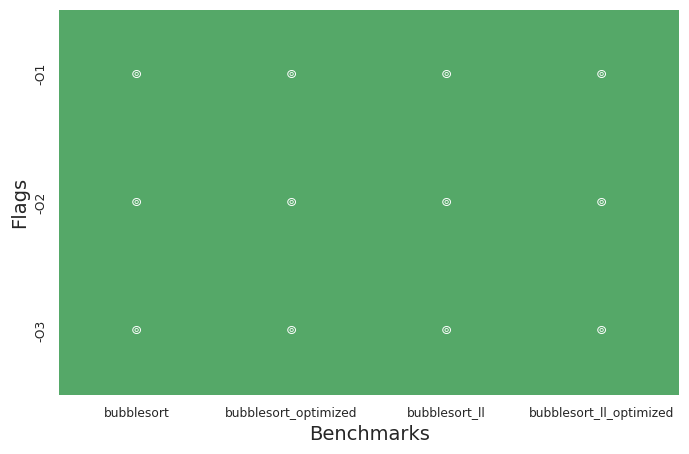

In [ ]:
labels = heat_df.pivot_table(index=['flag'], columns=['prog'], values='test', sort=False)
labels = labels.replace(0, ' ')
labels = labels.replace(1, '⨯')
labels = labels.replace(2, '⊚')

colors, categories = [], heat_df['category'].unique()
colors.append("#dd8452") if -1 in categories else _ # orange
colors.append("#4c72b0") if 0 in categories else _  # blue
colors.append("#55a868") if 1 in categories else _  # green

plt.figure(figsize=(8,5))
ax = sns.heatmap(
    data = heat_df.pivot_table(index='flag', columns='prog', values='category', sort=False),
    cmap = sns.color_palette(colors, as_cmap=True),
    xticklabels=True, yticklabels=True, cbar = False,
    annot= labels,
    fmt= ''
)
ax.set_ylabel("Flags", fontsize=14)
ax.set_xlabel("Benchmarks", fontsize=14)
plt.savefig(f"charts/{DATA_COL}_heat.pdf", bbox_inches='tight')
# plt.show()

# orange: effsize < 0 => increase in consumption
# blue: no significant difference
# green: effsize > 0 => decrease in consumption

# ⨯: anova  ⊚: random sampling

## Percentual Decrease

Calculate the percentual decrese of a program compiled with a flag in relation to `-O0`

In [89]:
n_flags = list(flags)
n_flags.remove('-O0')

perc_df = []

for prog in progs:
    energy_base = df[(df['flag'] == '-O0') & (df['prog'] == prog)][DATA_COL].mean()

    for flag in n_flags:
        energy_flag = df[(df['flag'] == flag) & (df['prog'] == prog)][DATA_COL].mean()
        decrease = ((energy_base - energy_flag) / energy_base) * 100
        
        perc_df.append([prog, flag, energy_base, energy_flag, decrease])

perc_df = pd.DataFrame(perc_df, columns=['prog', 'flag', 'base energy', 'flag energy', 'decrease'])
perc_df

,prog,flag,base energy,flag energy,decrease
0,bubblesort,-O1,285.564414,174.619158,38.851219
1,bubblesort,-O2,285.564414,139.648813,51.097264
2,bubblesort,-O3,285.564414,267.242286,6.416110
3,bubblesort_optimized,-O1,285.948244,175.179536,38.737327
4,bubblesort_optimized,-O2,285.948244,140.192345,50.972825
5,bubblesort_optimized,-O3,285.948244,267.994427,6.278694
6,bubblesort_ll,-O1,354.086307,260.378700,26.464623
7,bubblesort_ll,-O2,354.086307,209.274018,40.897455
8,bubblesort_ll,-O3,354.086307,210.146565,40.651033
9,bubblesort_ll_optimized,-O1,548.390060,395.579954,27.865222


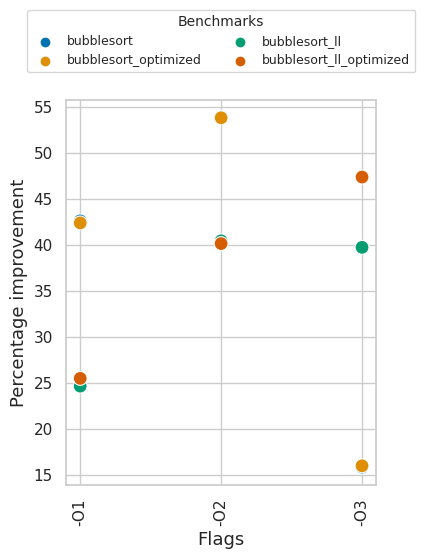

In [17]:
# sns.set_palette('colorblind', 12)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(4,5))
plt.xticks(rotation=90)

# ax = sns.scatterplot(data=perc_df[perc_df['Benchmark'] == 'Others'], x='flag', y='decrease', hue='Benchmark', 
#     palette= {'Others': to_rgba('#949494', 0.4)})
ax = sns.scatterplot(data=perc_df, x='flag', y='decrease', hue='prog', palette=sns.color_palette(palette="colorblind", n_colors=4), s=100)
ax.legend(loc="upper center", bbox_to_anchor=(0.5,1.25), ncols=2, title='Benchmarks', fontsize=9, title_fontsize=10)
sns.set(font_scale=2)
ax.set_ylabel("Percentage improvement", fontsize=13)
ax.set_xlabel("Flags", fontsize=13)
plt.savefig(f"charts/{DATA_COL}_scatter.pdf", bbox_inches='tight')
# plt.show()

sns.set(font_scale=1)

['-O1', '-O2', '-O3']


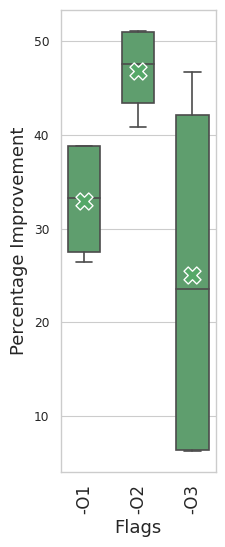

In [34]:
custom_palette = {}
print(n_flags)
for flag in n_flags:
    avr = perc_df[(perc_df['flag'] == flag)]['decrease'].mean()
    med = perc_df[(perc_df['flag'] == flag)]['decrease'].median()

    # green if med >= 0 else orange
    custom_palette[flag] = "#55a868" if med >= 0 else "#dd8452"

plt.figure(figsize=(2,6))
sns.set_theme(style="whitegrid")
sns.set_context("paper")
plt.xticks(rotation=90)

ax = sns.boxplot(data=perc_df, x="flag", y="decrease", 
    palette = custom_palette,
    flierprops=dict(marker='o', markerfacecolor='None', markersize=5, markeredgecolor='black'), width=.6)
df_means = perc_df.groupby("flag")['decrease'].agg('mean').reset_index()
ax = sns.scatterplot(data=df_means[df_means['decrease'] >= 0], x="flag", y="decrease", marker='X', color="#55a868", s=150, zorder=3, ax=ax, legend=False)
ax = sns.scatterplot(data=df_means[df_means['decrease'] < 0], x="flag", y="decrease", marker='X', color="#dd8452", s=150, zorder=3, ax=ax, legend=False)

plt.xticks(fontsize=12)
# plt.ylim(-7, 7)
ax.set_ylabel("Percentage Improvement", fontsize = 13)
# ax.yaxis.set_label_coords(-.05, .5)
ax.set_xlabel("Flags", fontsize = 13)
plt.savefig(f"charts/{DATA_COL}_box.pdf", bbox_inches='tight')
# plt.show()

## Energy-Time Correlation

In [35]:
ENERGY_COL = 'pkg'
TIME_COL = 'time'

# pearson's correlation coefficient
corr, pvalue = stats.pearsonr(df[ENERGY_COL], df[TIME_COL])
print(f"Pearson  | coef: {corr}\t | p: {pvalue}")

# spearman's correlation coefficient
corr, pvalue = stats.spearmanr(df[ENERGY_COL], df[TIME_COL])
print(f"Spearman | coef: {corr}\t | p: {pvalue}")

Pearson  | coef: 0.9951002327961508	 | p: 0.0
Spearman | coef: 0.9774380559481982	 | p: 0.0


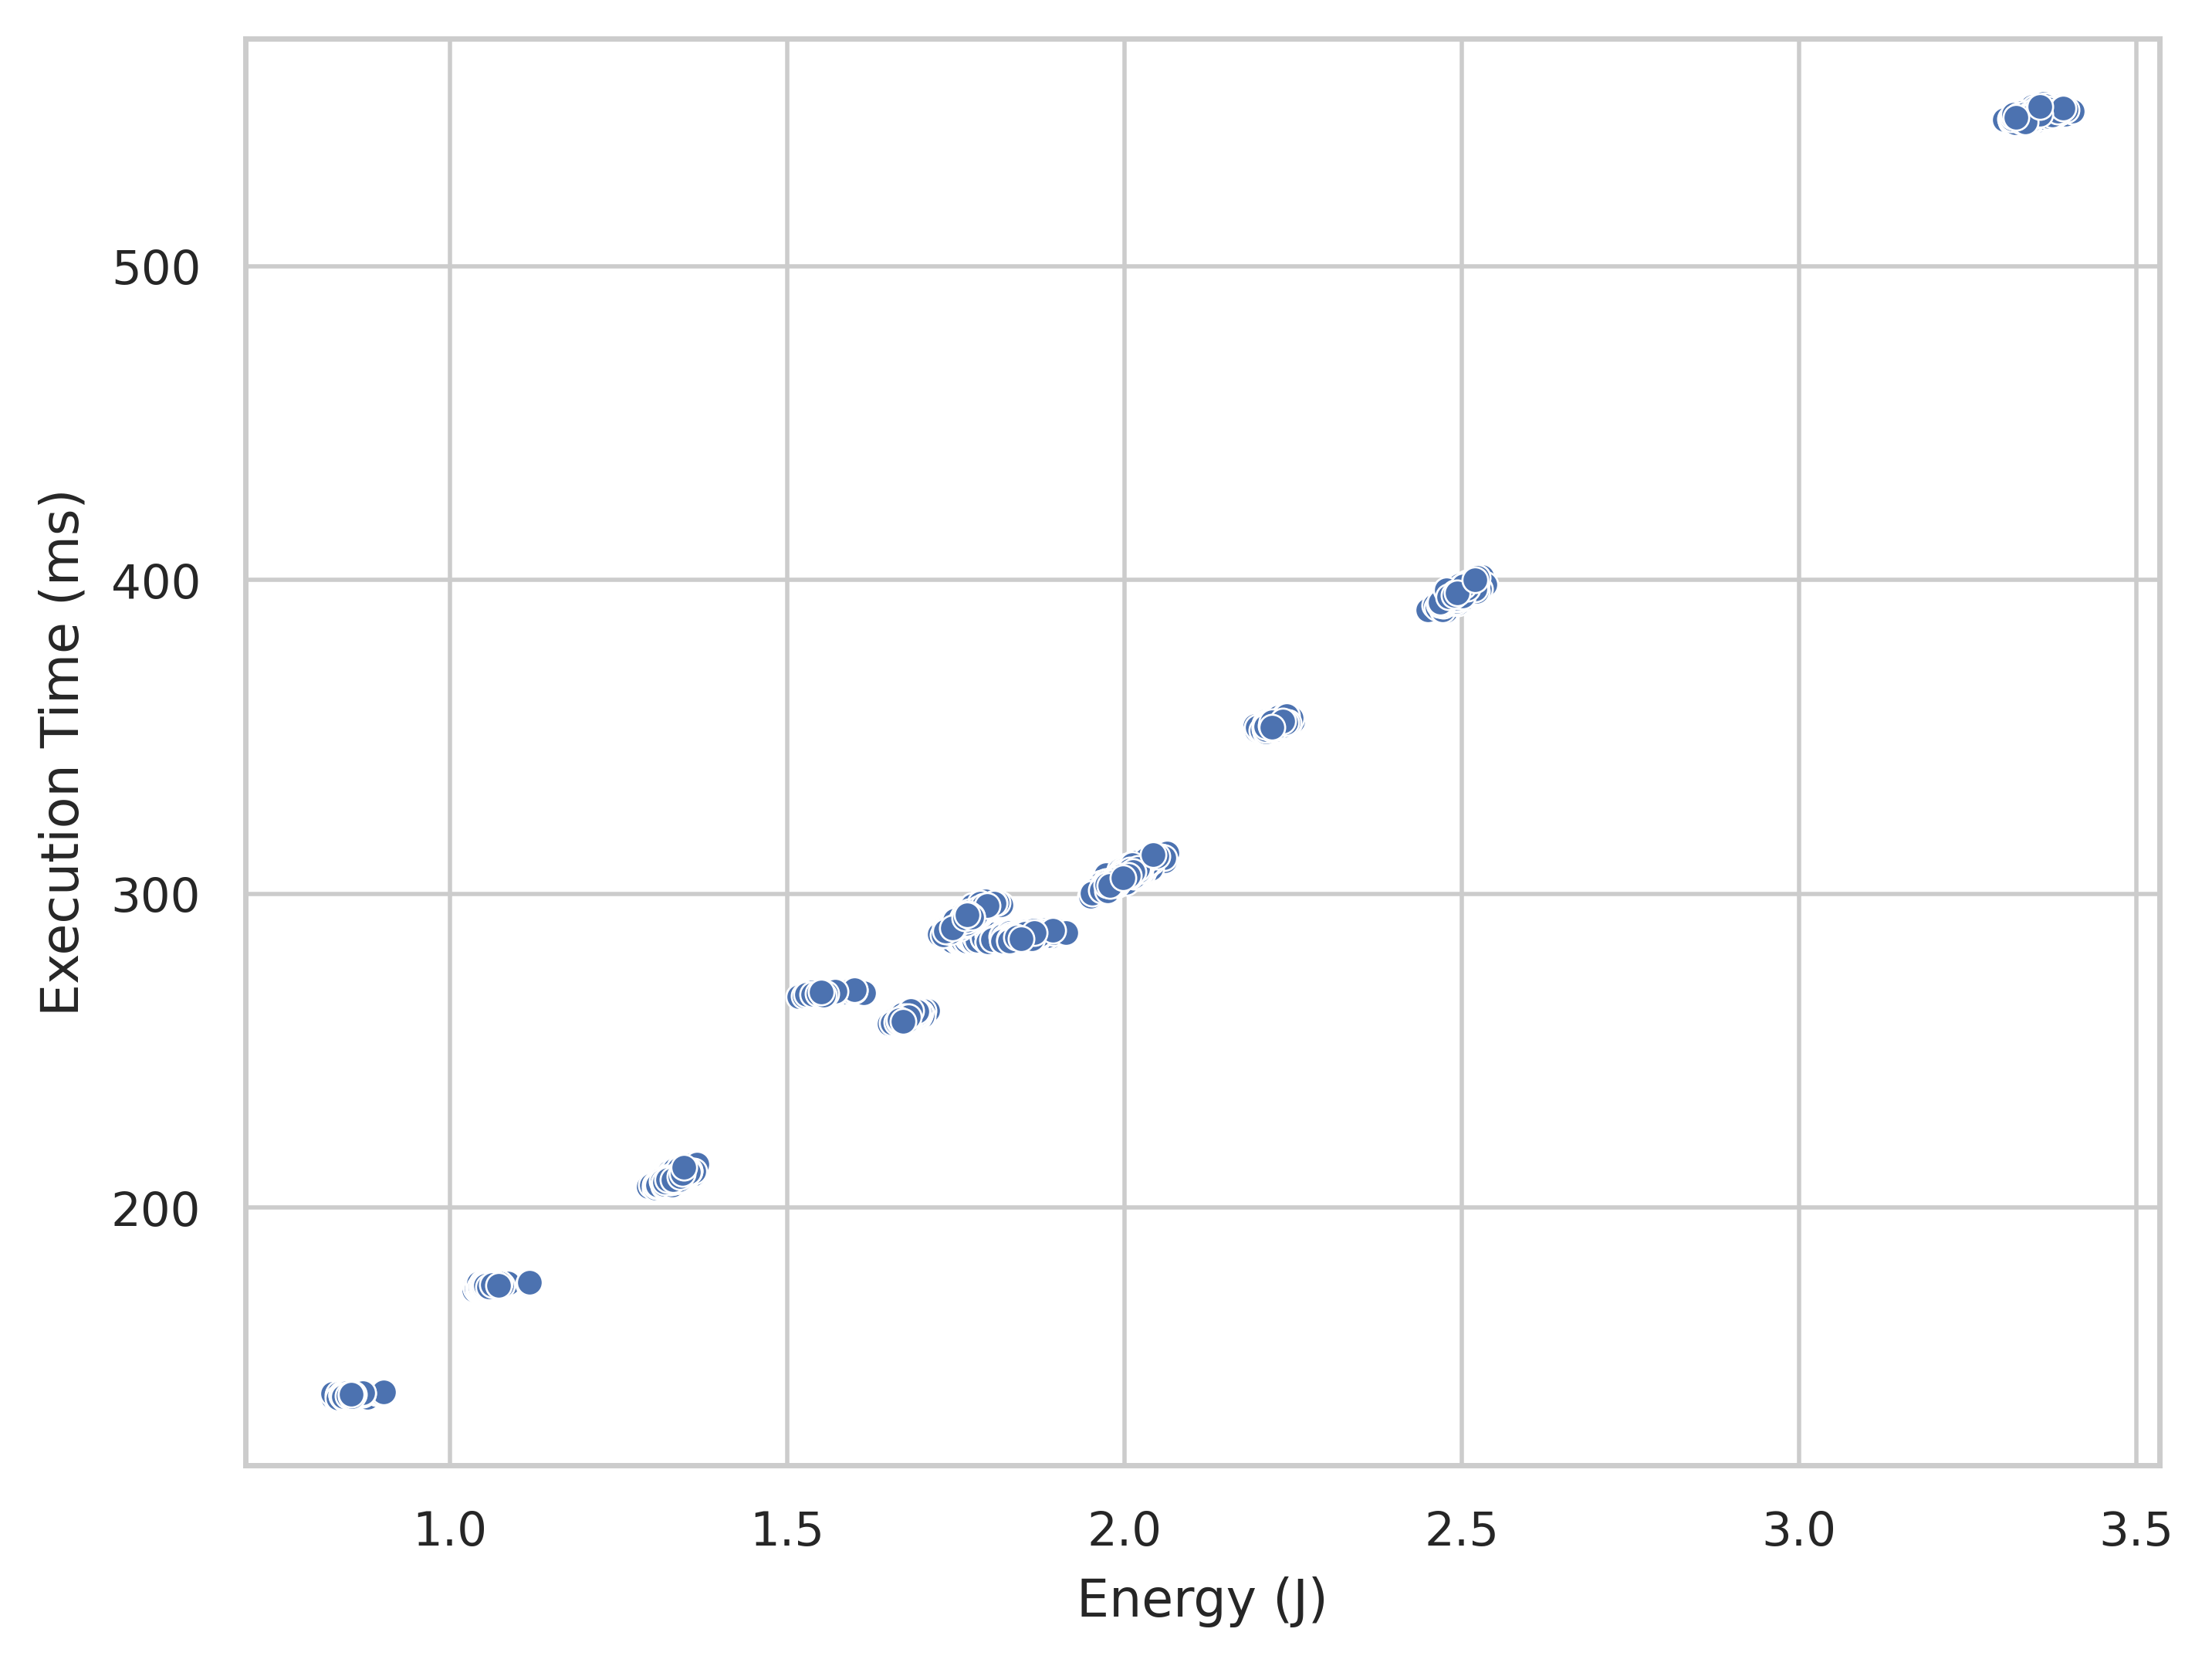

In [36]:
plt.figure(dpi=500)
# sns.scatterplot(df[df[ENERGY_COL] < 2000], x=ENERGY_COL, y=TIME_COL)
sns.scatterplot(df, x=ENERGY_COL, y=TIME_COL)
plt.xlabel('Energy (J)')
plt.ylabel('Execution Time (ms)')
plt.savefig(f"charts/{DATA_COL}_correlation.pdf", bbox_inches='tight')
plt.show()

In [37]:
norm_df['spearman_coef'] = [0.0] * len(norm_df)
norm_df['spearman_p'] = [0.0] * len(norm_df)

for prog in progs:    
    for flag in flags:
        data = df[(df['prog'] == prog) & (df['flag'] == flag)]

        if len(data) < 1: continue

        i = norm_df.index[(norm_df['prog'] == prog) & (norm_df['flag'] == flag)].values[0]
        coef, pvalue = stats.spearmanr(data[ENERGY_COL], data[TIME_COL])

        norm_df.at[i, 'spearman_coef'] = coef
        norm_df.at[i, 'spearman_p'] = pvalue

norm_df

,prog,flag,shapiro,agostino,anderson,normal,levene,anova,random,cohend,hedgesg,spearman_coef,spearman_p
0,bubblesort,-O0,False,False,False,False,False,False,False,0.000000,0.000000,-0.029510,5.694109e-01
1,bubblesort,-O1,True,True,True,True,False,False,True,158.611427,157.360532,0.351661,6.981278e-13
2,bubblesort,-O2,True,True,True,True,False,False,True,214.234251,212.602371,0.337838,7.238761e-12
3,bubblesort,-O3,True,True,True,True,False,False,True,26.410170,26.171978,0.194354,1.012403e-04
4,bubblesort_optimized,-O0,False,False,False,False,False,False,False,0.000000,0.000000,0.364761,6.282312e-13
5,bubblesort_optimized,-O1,False,False,False,False,False,False,True,163.967008,163.565576,0.371662,1.348162e-13
6,bubblesort_optimized,-O2,True,True,True,True,False,False,True,217.306730,216.223818,0.439650,2.993539e-19
7,bubblesort_optimized,-O3,False,False,False,False,False,False,True,26.373672,26.449201,0.379730,1.005226e-13
8,bubblesort_ll,-O0,True,True,True,True,False,False,False,0.000000,0.000000,0.624181,8.777025e-42
9,bubblesort_ll,-O1,False,False,False,False,False,False,True,100.307310,100.316925,0.758612,9.166968e-72


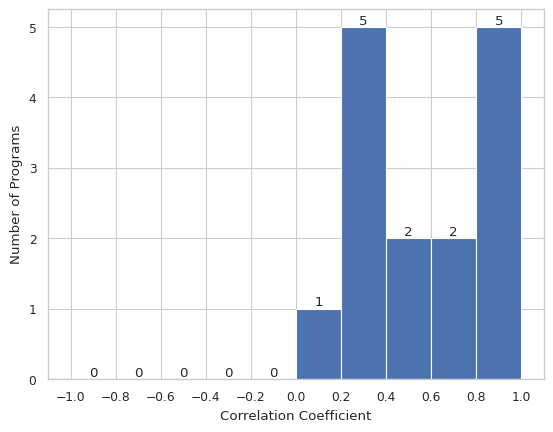

In [38]:
bins = [-1,-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1]

data=norm_df[norm_df['spearman_p'] < 0.05]
# chart = sns.histplot(corr_df, x='correlation', bins=bins).set(xlabel='Correlation Coefficient', xticks=bins)
counts, edges, bars = plt.hist(x=data['spearman_coef'], bins=bins)
plt.xticks(bins)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Number of Programs')
# plt.grid()
plt.bar_label(bars)
plt.savefig(f"charts/{DATA_COL}_corr_hist.pdf", bbox_inches='tight')

# plt.show()